# Text Analytics Coursework: PART 1--Tweet Emotion Classification

In [133]:
# Use HuggingFace's datasets library to access the Emotion dataset
from datasets import load_dataset
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
import string
import nltk
import re
from nltk.corpus import stopwords, wordnet
from nltk import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, TfidfModel
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud

# %load_ext autoreload
# %autoreload 2

# Part 1: Tweet Emotion Classification
# 1. Load the dataset
Use the TweetEval dataset from HuggingFace's datasets library to load the Emotion dataset. The dataset has three splits: train, validation, and test. Load the train, validation, and test splits into separate variables.
The labels in the dataset are: [0,1,2,3] which correspond to the emotions: [anger, joy, optimism, sadness].

In [80]:
cache_dir = "./NLP_data_cache"

train_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="train",
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset)} instances loaded")


val_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="validation",
    cache_dir=cache_dir,
)
print(f"Development/validation dataset with {len(val_dataset)} instances loaded")


test_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="test",
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset)} instances loaded")

# Access the input text and target labels like this...
train_texts = train_dataset['text']
train_labels = train_dataset['label']

val_texts = val_dataset['text']
val_labels = val_dataset['label']

test_texts = test_dataset['text']
test_labels = test_dataset['label']

Training dataset with 3257 instances loaded
Development/validation dataset with 374 instances loaded
Test dataset with 1421 instances loaded


In [3]:
train_texts[13], train_labels[13]

('What a fucking muppet.  @user  #stalker.', 0)

# 2. Non-Neural Classifier
## 2.1. Preprocessing
### 2.1.1. Text Cleaning

The text cleaning step includes removing URLs, @mentions and #hashtags, converting to lowercase, removing punctuation. Lexical annotation and word form reduction by the result of lexical annotation. These steps help to reduce the noise and diversity of text data and improve the performance of text analysis.

In [81]:
# 确保已下载nltk的wordnet和stopwords数据包
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) # 加载停用词

# 映射nltk的词性标签到wordnet的词性标签。用于词形还原
def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE) # 移除URLs
    text = re.sub(r'\@\w+|\#','', text) # 移除@mentions和hashtags
    text = text.lower() # 转换为小写
    text = text.translate(str.maketrans("", "", string.punctuation)) # 移除标点符号
    
    tokens = word_tokenize(text) # 分词
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 2] # 删除停用词和短词(长度小于等于2)

    nltk_tagged = nltk.pos_tag(filtered_tokens)   # 词性标注
    wordnet_tagged = map(lambda x: (x[0], nltk_pos_tagger(x[1])), nltk_tagged) # 转换词性标注
    
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)


# 应用词形还原到你的文本数据
train_texts_lemmatized = [lemmatize_text(text) for text in train_texts]
val_texts_lemmatized = [lemmatize_text(text) for text in val_texts]
test_texts_lemmatized = [lemmatize_text(text) for text in test_texts]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yhb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\yhb\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yhb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [82]:
train_texts_lemmatized[0:3]

['worry payment problem may never joyce meyer motivation leadership worry',
 'roommate okay cant spell autocorrect terrible firstworldprobs',
 'thats cute atsu probably shy photo cherry help uwu']

### 2.1.2. Vectorization
Use the TF-IDF vectorizer to convert the text data into numerical form.

In [83]:
# TF-IDF向量化
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

# 将训练和验证数据集合并进行向量化，这样可以提高模型的泛化能力
X_all_lemmatized = train_texts_lemmatized + val_texts_lemmatized
y_all = train_labels + val_labels

# 向量化处理
X_all_tfidf = tfidf_vectorizer.fit_transform(X_all_lemmatized)
X_test_tfidf = tfidf_vectorizer.transform(test_texts_lemmatized)

# 分割数据集，这里重新分割是因为我们合并了训练集和验证集进行统一的向量化
x_train_tfidf, x_val_tfidf, y_train, y_val = train_test_split(
    X_all_tfidf, y_all, test_size=0.2, random_state=42)

## 2.2. Classification Model

In [84]:
# grid search
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10,100],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=5, n_jobs=-1,verbose=True)
grid_search.fit(x_train_tfidf, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)
print("Best estimator: ", grid_search.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters:  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score:  0.6683880348982136
Best estimator:  SVC(C=100, class_weight='balanced', gamma=0.01)


In [86]:
# 训练SVM模型
# C是正则化参数，C越大，正则化越弱，则模型越容易过拟合；gamma是rbf核函数的系数，gamma越大，模型越容易过拟合
svm_model = SVC(random_state=42, kernel='rbf', C=100, gamma=0.01,class_weight='balanced')
svm_model.fit(x_train_tfidf, y_train)

# 预测验证集
y_train_pred = svm_model.predict(x_train_tfidf)
y_val_pred = svm_model.predict(x_val_tfidf)
y_test_pred = svm_model.predict(X_test_tfidf)

print("Train Accuracy: ", accuracy_score(y_train, y_train_pred))
print("Classification Report:\n", classification_report(y_train, y_train_pred))

# 性能评估
print("Validation Accuracy: ", accuracy_score(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))

# 测试集性能评估
print("Test Accuracy: ", accuracy_score(test_labels, y_test_pred))
print("Test Classification Report:\n", classification_report(test_labels, y_test_pred))

Train Accuracy:  0.9755509641873278
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      1257
           1       0.98      0.99      0.98       648
           2       0.94      1.00      0.97       249
           3       0.96      0.98      0.97       750

    accuracy                           0.98      2904
   macro avg       0.97      0.98      0.97      2904
weighted avg       0.98      0.98      0.98      2904

Validation Accuracy:  0.6643741403026134
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.81      0.75       303
           1       0.65      0.62      0.64       157
           2       0.53      0.26      0.35        73
           3       0.63      0.63      0.63       194

    accuracy                           0.66       727
   macro avg       0.63      0.58      0.59       727
weighted avg       0.65      0.66      0.65       727

Test 

In [87]:
# cross validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svm_model, X_all_tfidf, y_all, cv=5, scoring='f1_macro',n_jobs=-1)
print("Cross-validation scores: ", scores)
print("Mean CV F1-score: ", scores.mean())

Cross-validation scores:  [0.60740998 0.58755987 0.60109544 0.63295582 0.55060438]
Mean CV F1-score:  0.5959250967328409


## 2.3 Improving the Model
Add Lexicon Features, using NLTK's VADER sentiment analysis tool to extract sentiment scores from the text data. Add these sentiment scores as additional features to the TF-IDF vectorized features.

In [88]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# 实例化情感分析器
analyser = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\yhb\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [89]:
from scipy.sparse import hstack

# 初始化VADER情感分析器
sia = SentimentIntensityAnalyzer()

X_all_lemmatized = train_texts_lemmatized + val_texts_lemmatized
y_all = train_labels + val_labels

# 计算情感分数 # compound是综合得分
x_all_sentiments = [sia.polarity_scores(text)['compound'] for text in X_all_lemmatized]
x_test_sentiments = [sia.polarity_scores(text)['compound'] for text in test_texts_lemmatized]

x_all_sentiments = np.array(x_all_sentiments).reshape(-1, 1)
x_test_sentiments = np.array(x_test_sentiments).reshape(-1, 1)

# 合并情感分数和TF-IDF特征
# 向量化处理
X_all_tfidf = tfidf_vectorizer.fit_transform(X_all_lemmatized)
X_test_tfidf = tfidf_vectorizer.transform(test_texts_lemmatized)

X_all = hstack([X_all_tfidf, x_all_sentiments])
X_test = hstack([X_test_tfidf, x_test_sentiments])

# 分割数据集
x_train_augmented, x_val_augmented, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42)

In [91]:
# 训练SVM模型
svm_model_vader = SVC(random_state=42, kernel='rbf', C=100, gamma=0.01,class_weight='balanced')
svm_model_vader.fit(x_train_augmented, y_train)

# 预测验证集
y_train_pred = svm_model_vader.predict(x_train_augmented)
y_val_pred = svm_model_vader.predict(x_val_augmented)
y_test_pred = svm_model_vader.predict(X_test)

print("Train Accuracy: ", accuracy_score(y_train, y_train_pred))
print("Classification Report:\n", classification_report(y_train, y_train_pred))

# 性能评估
print("Validation Accuracy: ", accuracy_score(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))

# 测试集性能评估
print("Test Accuracy: ", accuracy_score(test_labels, y_test_pred))
print("Test Classification Report:\n", classification_report(test_labels, y_test_pred))

Train Accuracy:  0.974862258953168
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      1257
           1       0.97      0.99      0.98       648
           2       0.94      1.00      0.97       249
           3       0.96      0.98      0.97       750

    accuracy                           0.97      2904
   macro avg       0.97      0.98      0.97      2904
weighted avg       0.98      0.97      0.97      2904

Validation Accuracy:  0.6808803301237965
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.81      0.77       303
           1       0.62      0.66      0.64       157
           2       0.54      0.29      0.38        73
           3       0.68      0.65      0.66       194

    accuracy                           0.68       727
   macro avg       0.64      0.60      0.61       727
weighted avg       0.67      0.68      0.67       727

Test A

In [19]:
# 查看分类错误的样本
test_df = test_dataset.to_pandas()
test_df['pred'] = y_test_pred
test_df['gold_label'] = test_labels
mistakes = test_df[test_df['pred'] != test_df['gold_label']]
mistakes
# mistakes.to_csv('./NLP_data_cache/mistakes.csv', index=False)

,text,label,pred,gold_label
8,@user @user #cmbyn does screen August 4 &amp;...,3,1,3
12,Yes #depression &amp; #anxiety are real but so...,3,1,3
15,@user #shocking loss of talented young man#pra...,3,0,3
23,@user @user Americans do not spank their child...,2,0,2
25,Favorite character who's name starts with the ...,1,2,1
...,...,...,...,...
1405,Why would Mourinho be talking about Lacazette?...,0,1,0
1414,@user First it was steaming pussy with garlic ...,3,0,3
1417,@user I've finished reading it; simply mind-bl...,3,1,3
1418,shaft abrasions from panties merely shifted to...,0,3,0


In [21]:
test_texts[12], test_labels[12]

('Yes #depression &amp; #anxiety are real but so is bein #grateful &amp; #happiness \\nI choose how i wanna live MY life not some disorder',
 3)

### Insights
比较添加情感分数特征前后的性能，发现分类器的性能有所提升。这表明情感分数特征对于情感分类任务是有用的。
具体表现为：对于类别1（joy），recall显著提高，对于类别2（optimise），precision显著提高。这表明模型能够更好地识别这两个类别。这可能是因为情感得分提供了一种直接量化文本情感倾向的方式，帮助模型捕捉到了一些仅通过文本内容难以明确表达的情感特征。这一结果表明，对于文本分类任务，结合内容分析和情感倾向的量化分析，可以有效提升模型的预测准确性和泛化能力。

Comparing the performance before and after adding the sentiment score feature, it is found that the performance of the classifier has improved. This indicates that the sentiment score feature is useful for the sentiment classification task.

This is shown by the significant improvement in Recall for category 1 (Joy) and Precision for category 2 (Optimise). This indicates that the model is better able to recognize these two categories. This may be due to the fact that the sentiment score provides a way to directly quantify the sentiment tendency of the text, helping the model to capture some of the sentiment features that are difficult to express explicitly through the text content alone. This result suggests that for text categorization tasks, combining content analysis and quantitative analysis of sentiment tendencies can effectively improve the prediction accuracy and generalization ability of the model.


# 3. Deep Learning Classifier
## 3.1. Preprocessing
### 3.1.1. Length of Texts
We found that the maximum length of the text data is 36. As the hist plot can show the distribution of the length of the text data, we can see that most of the text data is less than 25 words. Therefore, we can set the maximum length of the text data to 25.

36

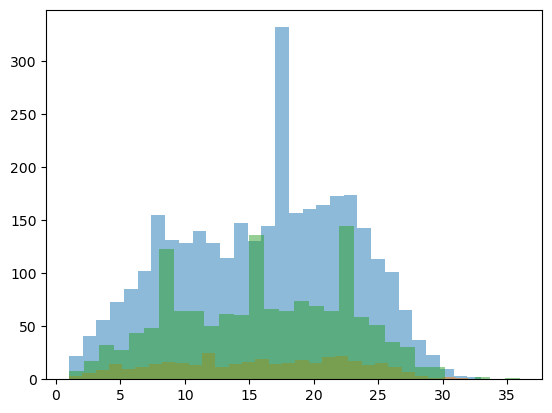

In [11]:
# 查看样本长度的分布
import matplotlib.pyplot as plt

train_texts_len = [len(text.split()) for text in train_texts]
val_texts_len = [len(text.split()) for text in val_texts]
test_texts_len = [len(text.split()) for text in test_texts]

plt.hist(train_texts_len, bins=30, alpha=0.5, label='train')
plt.hist(val_texts_len, bins=30, alpha=0.5, label='val')
plt.hist(test_texts_len, bins=30, alpha=0.5, label='test')

# 找出最长长度
max_len = max(max(train_texts_len), max(val_texts_len), max(test_texts_len))
max_len

### 3.1.2. Tokenization, Encoding, Padding&Truncating and Tensorization
Use BERT tokenizer to tokenize the text data. Then convert the tokenized text data into vocabulary index. Finally, pad and tensorize the text data and generate the DataLoader.

In [23]:
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_texts(texts):
    return tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,  # 添加特殊标记，例如[CLS]和[SEP]
        max_length=30,  # 设定最大序列长度
        padding='max_length',  # 进行填充以达到相同长度
        truncation=True,  # 截断超过最大长度的部分
        return_attention_mask=True,  # 返回attention_mask（区分填充和非填充部分）
        return_token_type_ids=False,  # 不返回token_type_ids(用于区分两个句子，如问答，本模型不需要)
        return_tensors='pt'  # 返回PyTorch张量
    )

# 对训练、验证和测试数据进行编码
encoded_train = encode_texts(train_texts)
encoded_val = encode_texts(val_texts)
encoded_test = encode_texts(test_texts)

In [24]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}  # 确保不修改原始数据
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

batch_size = 64

# 创建Dataset
train_dataset = TextDataset(encoded_train, train_labels)
val_dataset = TextDataset(encoded_val, val_labels)
test_dataset = TextDataset(encoded_test, test_labels)

# 创建DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [25]:
train_loader.dataset[13]

{'input_ids': tensor([  101,  2054,  1037,  8239, 14163, 29519,  1012,  1030,  5310,  1001,
         23883,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]),
 'labels': tensor(0)}

## 3.2. Training the Model
Download the pre-trained BERT model and fine-tune it on the emotion classification task.

In [26]:
from torch import nn
import torch.nn.functional as F

# 使用Focal Loss作为损失函数
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        """
        inputs: logits
        targets: 真实标签
        """
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # 计算概率
        F_loss = (1 - pt) ** self.gamma * BCE_loss
        
        if self.alpha is not None:
            at = self.alpha[targets]
            F_loss = at * F_loss
        
        return F_loss.mean()

In [33]:
from tqdm import tqdm
import torch
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def train(model, train_dataloader, val_dataloader, optimizer, scheduler, device, epochs):
    train_losses = []
    val_losses = []
    train_f1score = []  
    val_f1score = []
    
    # 如果需要使用带权重的交叉熵损失函数：
    # 类别的样本数量(训练集）
    class_counts = torch.tensor([1400, 708, 294, 855])
    # 计算每个类别的权重（以最小类别样本数的倒数作为基础）
    weights = class_counts.min().float() / class_counts.float()
    weights = weights.to(device)
    # custom_loss_function = CrossEntropyLoss(weight=weights) # 使用带权重的交叉熵损失
    custom_loss_function = FocalLoss(alpha=weights, gamma=2.0) # 使用Focal Loss
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        all_train_preds = []  
        all_train_labels = []
        
        # for batch in tqdm(train_dataloader, desc="Training"):
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()} 
            # 这行代码遍历从DataLoader迭代器返回的每个批次数据中的所有键值对。这里的batch是一个字典，它的键（k）是字符串，比如'input_ids'、'attention_mask'和'labels'，值（v）是对应的数据张量。{k: v.to(device) for k, v in batch.items()}这部分代码的作用是：
            # 对于字典中的每个键值对，将值（即张量）移动到指定的device（例如，GPU或CPU）。
            
            # # 使用BERT内置损失函数进行反向传播
            # outputs = model(**batch)  # **batch将字典解包为关键字参数   
            # loss = outputs.loss
            # loss.backward()
            
            # 使用自定义损失函数进行反向传播
            outputs = model(**batch)
            logits = outputs.logits  # 获取模型的logits
            # 计算自定义损失
            loss = custom_loss_function(logits, batch['labels'].to(device))
            # 使用自定义损失进行反向传播
            loss.backward()
            
            
            total_train_loss += loss.item()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # 梯度裁剪（防止梯度爆炸）
            
            optimizer.step()
            scheduler.step()
            model.zero_grad() 
            
            train_preds = torch.argmax(logits, dim=1).flatten()
            all_train_preds.extend(train_preds.cpu().numpy())
            all_train_labels.extend(batch['labels'].cpu().numpy())
        
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        
        train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')
        train_f1score.append(train_f1)
        
        # 验证过程
        model.eval()
        total_val_loss = 0 # 每个epoch都会重新计算验证集的损失
        val_accuracy = []
        all_preds = []
        all_labels = []
        
        # for batch in tqdm(val_dataloader, desc="Validating"):
        for batch in val_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}  
            
            with torch.no_grad():
                outputs = model(**batch) 
                
            loss = outputs.loss
            total_val_loss += loss.item()
            
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).flatten()
            labels = batch['labels']  # 获取标签进行准确度计算
            # 将当前批次的预测和标签追加到列表中
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            val_accuracy.append(accuracy_score(labels.cpu().numpy(), preds.cpu().numpy()))
        
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        
        # 计算f1-score
        val_f1 = f1_score(all_labels, all_preds, average='macro')
        val_f1score.append(val_f1)
        
        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss} | Val Loss: {avg_val_loss} | Val Accuracy: {np.mean(val_accuracy)}')
        print(classification_report(all_labels, all_preds))
        
        # 保存最终模型
        # if epoch == epochs - 1:
        torch.save(model.state_dict(), './NLP_data_cache/bert_model.pth')
        
    return train_losses, val_losses, train_f1score, val_f1score,model

In [30]:
import pandas as pd


def test(model, test_dataloader, device):
    model.eval()  # 设置模型为评估模式
    test_accuracy = []
    all_preds = []
    all_labels = []
    error_records = []  # 用于存储错误分类的记录
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    with torch.no_grad():  # 禁用梯度计算
        for batch in test_dataloader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}  # 保持labels之外的数据移至设备
            labels = batch['labels'].cpu().numpy()
            outputs = model(**inputs)  # 进行预测
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()  # 获取预测结果
            
            test_accuracy.append(accuracy_score(labels, preds))
            all_preds.extend(preds)
            all_labels.extend(labels)
            
            # 检查每个预测，并记录错误分类的实例
            input_ids = inputs['input_ids'].cpu().numpy()
            for input_id, pred, label in zip(input_ids, preds, labels):
                if pred != label:
                    decoded_sentence = tokenizer.decode(input_id, skip_special_tokens=True)
                    error_records.append([decoded_sentence, pred, label])

    avg_accuracy = np.mean(test_accuracy)
    print(f"Test Accuracy: {avg_accuracy}")
    print(classification_report(all_labels, all_preds))

    # 将错误记录保存到CSV文件
    df_errors = pd.DataFrame(error_records, columns=['Text', 'Predicted Label', 'True Label'])
    df_errors.to_csv('model_errors.csv', index=False)

    print(f"Saved {len(error_records)} error records to model_errors.csv")

    return all_preds, all_labels, avg_accuracy, error_records

In [36]:
from torch.optim import AdamW
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.nn import CrossEntropyLoss

# 加载预训练的BERT模型，指定分类数为4（你的情况下是0, 1, 2, 3四种情感）
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
epochs = 20
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 开始训练、验证和绘制损失曲线
train_losses, val_losses, train_f1score, val_f1score, model = train(model, train_loader, val_loader, optimizer, scheduler, device, epochs)
# 使用测试集进行最终评估
test(model, test_loader, device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 | Train Loss: 0.2186878814416773 | Val Loss: 0.9938718775908152 | Val Accuracy: 0.6413966049382717
              precision    recall  f1-score   support

           0       0.86      0.62      0.72       160
           1       0.70      0.59      0.64        97
           2       0.31      0.82      0.45        28
           3       0.59      0.69      0.63        89

    accuracy                           0.64       374
   macro avg       0.62      0.68      0.61       374
weighted avg       0.71      0.64      0.66       374
Test Accuracy: 0.6626254180602007
              precision    recall  f1-score   support

           0       0.82      0.62      0.70       558
           1       0.76      0.65      0.70       358
           2       0.33      0.73      0.46       123
           3       0.65      0.72      0.68       382

    accuracy                           0.66      1421
   macro avg       0.64      0.68      0.64      1421
weighted avg       0.72      0.66      0.68

([3,
  2,
  3,
  2,
  2,
  3,
  2,
  3,
  1,
  0,
  0,
  3,
  3,
  2,
  0,
  3,
  0,
  3,
  0,
  0,
  0,
  2,
  3,
  0,
  3,
  1,
  3,
  2,
  3,
  2,
  3,
  1,
  3,
  0,
  0,
  0,
  2,
  2,
  0,
  3,
  2,
  3,
  0,
  1,
  2,
  0,
  0,
  1,
  1,
  1,
  1,
  2,
  2,
  1,
  2,
  0,
  3,
  3,
  2,
  0,
  0,
  3,
  3,
  0,
  2,
  0,
  1,
  0,
  3,
  3,
  2,
  2,
  0,
  0,
  0,
  0,
  3,
  2,
  2,
  1,
  0,
  3,
  1,
  0,
  2,
  0,
  0,
  1,
  1,
  3,
  3,
  1,
  1,
  0,
  1,
  1,
  0,
  3,
  0,
  0,
  0,
  1,
  3,
  2,
  0,
  1,
  0,
  2,
  1,
  0,
  3,
  0,
  0,
  2,
  3,
  2,
  3,
  0,
  3,
  1,
  1,
  3,
  1,
  0,
  0,
  2,
  0,
  0,
  0,
  3,
  1,
  0,
  3,
  1,
  1,
  1,
  3,
  3,
  3,
  3,
  1,
  3,
  0,
  0,
  2,
  2,
  0,
  2,
  2,
  2,
  2,
  0,
  3,
  3,
  2,
  3,
  0,
  1,
  3,
  0,
  2,
  0,
  2,
  2,
  1,
  1,
  0,
  3,
  3,
  1,
  3,
  0,
  1,
  1,
  1,
  3,
  2,
  0,
  1,
  2,
  0,
  3,
  3,
  3,
  3,
  0,
  3,
  0,
  3,
  0,
  0,
  2,
  0,
  3,
  2,
  1,
  1,
  0,
  2,
  3,


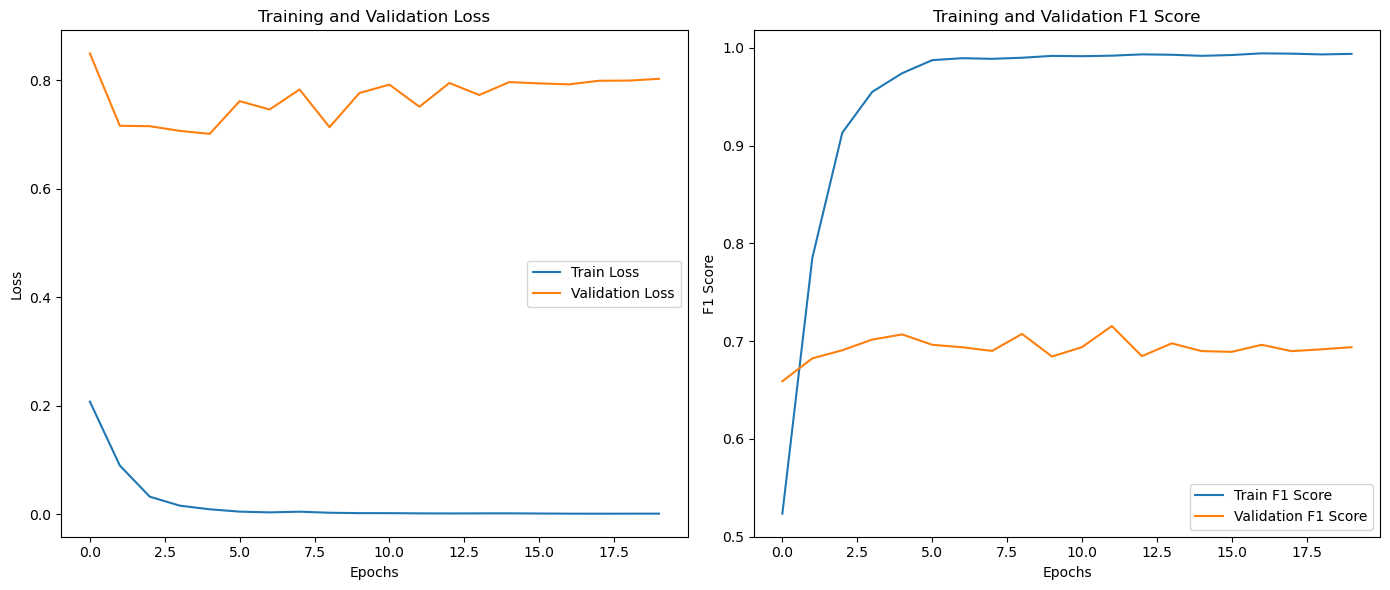

In [24]:
# 设置画板大小
plt.figure(figsize=(14, 6))

# 绘制损失曲线图
plt.subplot(1, 2, 1)  # 1行2列的第1个
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 绘制F1得分曲线图
plt.subplot(1, 2, 2)  # 1行2列的第2个
plt.plot(train_f1score, label='Train F1 Score')
plt.plot(val_f1score, label='Validation F1 Score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# 调整子图间距
plt.tight_layout()

# 保存图片到文件
# plt.savefig('./img/BERT_training_performance.png')

# 显示图表
plt.show()

# 4. Find the joyful and optimistic topics
## 4.1 Filter the Data
Find the text data with the labels of joy and optimism.

In [95]:
# 定义一个函数来筛选特定标签的文本
def filter_texts_by_labels(texts, labels, target_labels):
    filtered_texts = [text for text, label in zip(texts, labels) if label in target_labels]
    filtered_labels = [label for label in labels if label in target_labels]
    return filtered_texts, filtered_labels

# 设置目标标签：1 (joy) 和 2 (optimism)
target_labels = [1, 2]

# 筛选训练集中的文本和标签
train_texts_filtered, train_labels_filtered = filter_texts_by_labels(train_texts, train_labels, target_labels)

# 筛选验证集中的文本和标签
val_texts_filtered, val_labels_filtered = filter_texts_by_labels(val_texts, val_labels, target_labels)

# 筛选测试集中的文本和标签
test_texts_filtered, test_labels_filtered = filter_texts_by_labels(test_texts, test_labels, target_labels)

# 应用词形还原到你的文本数据
train_texts_lemmatized = [lemmatize_text(text) for text in train_texts_filtered]
val_texts_lemmatized = [lemmatize_text(text) for text in val_texts_filtered]
test_texts_lemmatized = [lemmatize_text(text) for text in test_texts_filtered]
docs= train_texts_lemmatized + val_texts_lemmatized + test_texts_lemmatized
len(docs)

1608

## 4.2. Vectorization and Topic Modeling


In [105]:
docs_tokenized = [doc.split() for doc in docs]  # 分词
dictionary = Dictionary(docs_tokenized)

# BOW
corpus = [dictionary.doc2bow(doc) for doc in docs_tokenized]

# TF-IDF
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [127]:
# 构建LDA模型
# 使用词袋表示训练LDA
# lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=30) # num_topics是主题数, passes是迭代次数

# 或者使用TF-IDF表示训练LDA
lda_model_tfidf = LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5, passes=30)

topics = lda_model_tfidf.print_topics()
for topic in topics:
    print(topic)

(0, '0.003*"cheer" + 0.003*"know" + 0.003*"lol" + 0.002*"every" + 0.002*"get" + 0.002*"want" + 0.002*"love" + 0.002*"see" + 0.002*"never" + 0.002*"thanks"')
(1, '0.010*"lively" + 0.007*"amaze" + 0.007*"musically" + 0.007*"broadcast" + 0.006*"watch" + 0.003*"love" + 0.002*"like" + 0.002*"much" + 0.002*"hilarious" + 0.002*"time"')
(2, '0.004*"happy" + 0.004*"birthday" + 0.003*"dont" + 0.003*"fear" + 0.003*"get" + 0.002*"well" + 0.002*"amp" + 0.002*"day" + 0.002*"love" + 0.002*"worry"')
(3, '0.004*"hilarious" + 0.003*"make" + 0.002*"get" + 0.002*"fear" + 0.002*"day" + 0.002*"feel" + 0.002*"literally" + 0.002*"thing" + 0.002*"delight" + 0.002*"dream"')
(4, '0.005*"love" + 0.003*"really" + 0.003*"look" + 0.002*"like" + 0.002*"people" + 0.002*"amp" + 0.002*"smile" + 0.002*"ill" + 0.002*"make" + 0.002*"want"')



1. **主题 0**: 这个主题似乎关注于正面情感和社交交流，如“cheer”（欢呼）、“know”（知道）、“lol”（笑）、“love”（爱）等词语出现。这些关键词暗示了一个轻松愉快的交流氛围，可能是关于朋友间的对话或社交媒体上的互动。

2. **主题 1**: 这个主题包含了“lively”（活泼的）、“amaze”（惊奇）、“musically”（音乐上）、“broadcast”（广播）等词，看起来它更多关注于娱乐和表演艺术，尤其是音乐和直播内容。这可能指的是与音乐、演出或在线直播相关的讨论或评论。

3. **主题 2**: 这个主题包括“happy”（快乐）、“birthday”（生日）、“fear”（恐惧）、“love”（爱），看上去像是关于个人生活的重大事件或感情表达，包括生日祝福、对未来的恐惧或希望，以及爱的表达。

4. **主题 3**: 包含“hilarious”（非常好笑）、“fear”（恐惧）、“delight”（高兴），这个主题似乎涉及幽默与感情的复杂性，可能反映了幽默作为应对生活中恐惧和挑战的一种方式。

5. **主题 4**: 这个主题以“love”（爱）、“really”（真的）、“look”（看起来）、“people”（人们）为主要词汇，可能关注于人际关系和情感表达，包括爱情、友情以及对于人性和外貌的观察。


In [128]:
# 评估模型
# 使用文档词袋表示计算一致性得分
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=docs_tokenized, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print(f'Coherence Score: {coherence_lda}')

Coherence Score: 0.4298813060941969


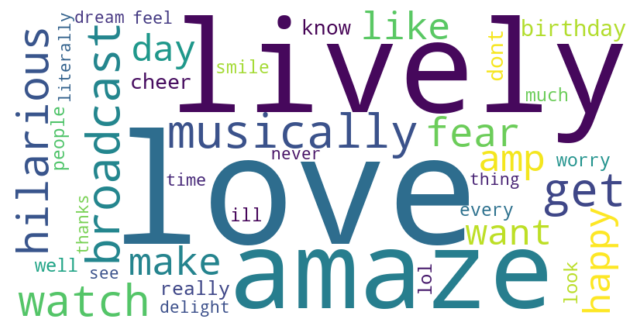

In [142]:
# 假设lda_model是你的LDA模型实例
num_topics = 5  # 你的模型的主题数量
topn = 10  # 你希望从每个主题中提取的关键词数量

topic_keywords = {}  # 初始化一个空字典来存储关键词及其权重

# 循环遍历每个主题
for topic_id in range(num_topics):
    # 使用show_topic获取当前主题的前N个重要单词及其权重
    for word, weight in lda_model_tfidf.show_topic(topic_id, topn=topn):
        # 为了生成词云，我们将每个单词的权重累加（如果单词在多个主题中出现）
        if word in topic_keywords:
            topic_keywords[word] += weight
        else:
            topic_keywords[word] = weight

# 确保topic_keywords字典包含了你想要显示在词云中的关键词和累计权重
# 生成词云
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_keywords)

# 显示词云
plt.figure(figsize=(8, 5))  # 设置图形的显示大小
plt.imshow(wordcloud, interpolation='bilinear')  # 使用双线性插值显示更平滑的图像
plt.axis('off')  # 不显示坐标轴

plt.savefig('./img/wordcloud.png')

plt.show()